In [ ]:
# ! pip install -q tensorflow-model-optimization

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.lite.python.util import convert_bytes_to_c_source
from tensorflow import saved_model
# import tensorflow_model_optimization as tfmot
import numpy as np
import matplotlib.pyplot as plt
import random
print(tf.__version__)

2.12.0


In [ ]:
dataset = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)
input_tensor_shape = (test_images.shape[1], test_images.shape[2], 1)
print("Input shape: {}".format(input_tensor_shape))

Input shape: (28, 28, 1)


In [ ]:
def to_c_array(values, ctype="float", name="table", formatter=str, colcount=28):
    # apply formatting to each element
    values = [formatter(v) for v in values]

    # split into rows with up to `colcount` elements per row
    rows = [values[i:i+colcount] for i in range(0, len(values), colcount)]

    # separate elements with commas, separate rows with newlines
    body = ',\n    '.join([', '.join(r) for r in rows])

    # assemble components into the complete string
    return '{} {}[] = {{\n    {}}};'.format(ctype, name, body)

In [ ]:
label = 6
indexes = np.where(train_labels == label)
index = random.choice(indexes[0])
print(f"index: {index} | label: {label}")
# print(train_images[index].flatten())

index: 35627 | label: 6


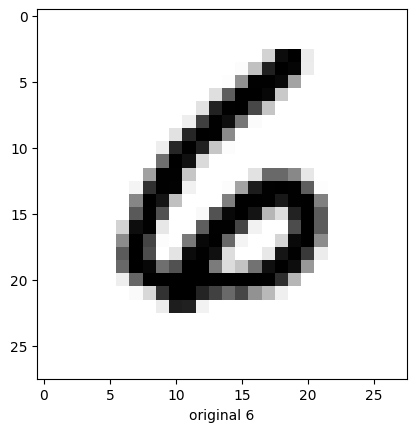

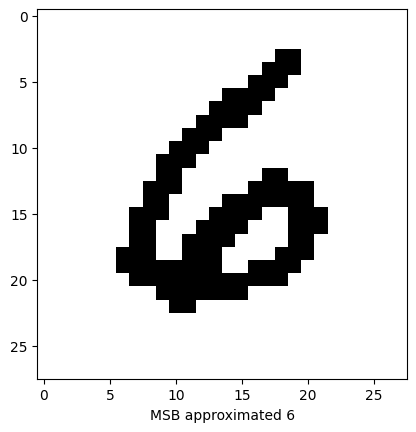

In [ ]:
plt.figure()
plt.imshow(train_images[index], cmap=plt.cm.binary)
plt.xlabel(f"original {train_labels[index]}")
plt.show()

apr_img = np.where(train_images[index] > 127, 255, 0)
plt.figure()
plt.imshow(apr_img, cmap=plt.cm.binary)
plt.xlabel(f"MSB approximated {train_labels[index]}")
plt.show()


In [ ]:
example = train_images[index].flatten()
example_signed = [x - 128 for x in example]
print(to_c_array(example_signed))

float table[] = {
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -85, 115, 127, -108, -128, -128, -128, -128, -128, -128, -128,
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -125, -66, 94, 126, 122, -109, -128, -128, -128, -128, -128, -128, -128,
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126, -18, 125, 125, 119, -37, -128, -128,

In [ ]:
example_apr = apr_img.flatten()
example_apr_sgn = [x - 128 for x in example_apr]
print(to_c_array(example_apr_sgn))

float table[] = {
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, 127, 127, -128, -128, -128, -128, -128, -128, -128, -128,
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, 127, 127, 127, -128, -128, -128, -128, -128, -128, -128, -128,
    -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, 127, 127, 127, -128, -128, 

In [ ]:
train_images = train_images.astype('float32')
test_images = train_images.astype('float32')

train_images -= 128
test_images -= 128
print(train_images.max())
print(train_images.min())

127.0
-128.0


In [ ]:
num_filters = 4
filter_size = (3, 3)
padding = "SAME"  # to preserve the output shape use "SAME"
use_bias = False
pool_size = (2, 2)

In [ ]:
# # define a custom layer. also needs to be implemented explicitly in TFLite C library
# class CustomConv(Conv2D):
#   def convolution_op(self, inputs, filter):
#     return tf.nn.conv2d(inputs,
#                         filter,
#                         strides=(1, 1), # default stride is (1, 1)
#                         padding=padding,
#                         name=self.__class__.__name__,)

In [ ]:
# @tf.function
# def customConv2Dfunc(inputs):
#   return tf.nn.conv2d(inputs,
#                       filter,
#                       strides=(1, 1), # default stride is (1, 1)
#                       padding=padding,
#                       name="customConv2Dfunc")

In [ ]:
model = Sequential([
    # CustomConv(filters=num_filters, kernel_size=filter_size, use_bias=use_bias, padding=padding, input_shape=input_tensor_shape),
    Conv2D(filters=num_filters, kernel_size=filter_size, use_bias=use_bias, padding=padding, input_shape=input_tensor_shape),
    MaxPooling2D(pool_size=pool_size),
    Flatten(),
    Dense(10, tf.nn.softmax),
])
model.summary()

# quantize_model = tfmot.quantization.keras.quantize_model
# model = quantize_model(model)
# print(model.weights)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 4)         36        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 4)        0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,886
Trainable params: 7,886
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 20s 10ms/step - loss: 4.0386 - accuracy: 0.8486
Epoch 2/3
1875/1875 [==============================] - 18s 10ms/step - loss: 0.6160 - accuracy: 0.9161
Epoch 3/3
1875/1875 [==============================] - 20s 10ms/step - loss: 0.3270 - accuracy: 0.9324


In [ ]:
def representative_dataset_gen():
  for image in test_images:
    array = np.array(image)
    array = np.expand_dims(array, axis=0)
    yield ([array])

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset_gen
converter.allow_custom_ops = True

tflite_model = converter.convert()

open("conv_model.tflite", "wb").write(tflite_model)
!xxd -i conv_model.tflite > conv_model_array.cc

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
# source_text, header_text = convert_bytes_to_c_source(tflite_model,  "tflite_model")

# with  open('/content/conv_model.h',  'w')  as  file:
#     file.write(header_text)

# with  open('/content/conv_model.cc',  'w')  as  file:
#     file.write(source_text)

In [ ]:
# !cat /content/conv_model_array.cc